In [1]:
import pandas as pd

# Load the dataset
df = pd.read_excel("ncaa_data.xlsx")

# Avoid division by zero
# Compute Field Goal Percentage (FG%) and Three-Point Percentage (3P%)
df["FG%"] = df["FGM"] / df["FGA"].replace(0, 1)  # Replace 0 in FGA to avoid errors
df["3P%"] = df["PM"] / df["PA"].replace(0, 1)  # Replace 0 in PA to avoid errors

# Save the updated dataset
updated_file_path = r"ncaa_newvalues.xlsx"
df.to_excel(updated_file_path, index=False)

print("Updated dataset saved successfully with FG% and 3P%!")

Updated dataset saved successfully with FG% and 3P%!


In [3]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Load the updated dataset
file_path = "ncaa_newvalues.xlsx"
df = pd.read_excel(file_path)

# Select relevant columns (including player names)
selected_features = ["Athlete", "Team Display Name", "FG%", "PTS", "3P%", "AST", "REB", "STL", "BLK"]
df_selected = df[selected_features]

# Aggregate by player name and take the median to remove duplicates
# Exclude non-numeric columns before applying median
numeric_columns = df_selected.select_dtypes(include=[np.number]).columns
player_stats = df_selected.groupby("Athlete")[numeric_columns].median().reset_index()

# Normalize the data (scale between 0 and 1 for clustering)
numeric_features = ["FG%", "PTS", "3P%", "AST", "REB", "STL", "BLK"]
player_stats_normalized = (player_stats[numeric_features] - player_stats[numeric_features].min()) / (player_stats[numeric_features].max() - player_stats[numeric_features].min())

# Convert to numpy array for Fuzzy C-Means clustering
data = player_stats_normalized.values.T  # Fuzzy C-Means requires transpose

# Number of clusters (5 positions: PG, SG, SF, PF, C)
num_clusters = 5

# Apply Fuzzy C-Means clustering
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data, num_clusters, m=2, error=0.005, maxiter=1000, init=None
)

# Print cluster centroids for manual inspection
centroids_df = pd.DataFrame(cntr, columns=numeric_features)
print("Cluster Centroids:")
print(centroids_df)

Cluster Centroids:
        FG%       PTS       3P%       AST       REB       STL       BLK
0  0.532538  0.314470  0.468623  0.130528  0.198564  0.109953  0.049281
1  0.509965  0.240216  0.061829  0.095926  0.270987  0.094048  0.093434
2  0.364442  0.134252  0.036721  0.068698  0.159920  0.059071  0.031017
3  0.412057  0.236466  0.229091  0.119326  0.199400  0.096352  0.046038
4  0.020296  0.013808  0.005196  0.017727  0.046870  0.013224  0.007545


In [6]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Load the updated dataset
file_path = "ncaa_newvalues.xlsx"
df = pd.read_excel(file_path)

# Select relevant columns (including player names)
selected_features = ["Athlete", "Team Display Name", "FG%", "PTS", "3P%", "AST", "REB", "STL", "BLK"]
df_selected = df[selected_features]

# Aggregate by player name and take the median to remove duplicates
# Exclude non-numeric columns before applying median
numeric_columns = df_selected.select_dtypes(include=[np.number]).columns
player_stats = df_selected.groupby("Athlete")[numeric_columns].median().reset_index()

# Normalize the data (scale between 0 and 1 for clustering)
numeric_features = ["FG%", "PTS", "3P%", "AST", "REB", "STL", "BLK"]
player_stats_normalized = (player_stats[numeric_features] - player_stats[numeric_features].min()) / (player_stats[numeric_features].max() - player_stats[numeric_features].min())

# Convert to numpy array for Fuzzy C-Means clustering
data = player_stats_normalized.values.T  # Fuzzy C-Means requires transpose

# Number of clusters (5 positions: PG, SG, SF, PF, C)
num_clusters = 5

# Apply Fuzzy C-Means clustering
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data, num_clusters, m=2, error=0.005, maxiter=1000, init=None
)

# Position weight matrix based on cluster analysis
position_weights = np.array([
    [0.1, 0.5, 0.4, 0.0, 0.0],  # Cluster 0 (SG/SF)
    [0.0, 0.0, 0.2, 0.5, 0.3],  # Cluster 1 (PF/C)
    [0.2, 0.3, 0.4, 0.1, 0.0],  # Cluster 2 (SF/SG)
    [0.0, 0.0, 0.0, 0.0, 0.0],  # Cluster 3 (Outliers)
    [0.6, 0.1, 0.2, 0.1, 0.0],  # Cluster 4 (PG)
])

# Compute weighted sum for each player to get soft position membership
soft_positions = np.dot(u.T, position_weights)

# Normalize each row to sum to 1
soft_positions = soft_positions / soft_positions.sum(axis=1, keepdims=True)

# Convert to DataFrame
position_labels = ["PG", "SG", "SF", "PF", "C"]
membership_df = pd.DataFrame(soft_positions, columns=position_labels)

# Add player stats and membership scores to final dataset
df_final = pd.concat([player_stats, membership_df], axis=1)

# Save the final dataset with soft classification
final_file_path = "ncaa_with_soft_positions.xlsx"
df_final.to_excel(final_file_path, index=False)

print("Fuzzy C-Means clustering completed! Updated dataset saved with soft position memberships.")


Fuzzy C-Means clustering completed! Updated dataset saved with soft position memberships.


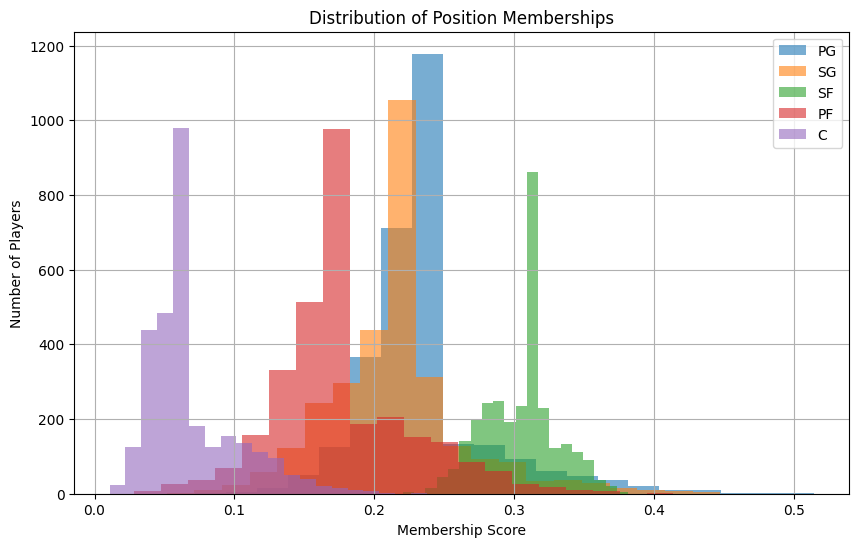

In [7]:
plt.figure(figsize=(10, 6))
for pos in position_labels:
    plt.hist(df_final[pos], bins=20, alpha=0.6, label=pos)
plt.xlabel("Membership Score")
plt.ylabel("Number of Players")
plt.title("Distribution of Position Memberships")
plt.legend()
plt.grid(True)
plt.show()